In [1]:
# %%
"""
# 📊 Dataset Setup and Analysis
Visual Intelligence Project - DeepLIFT Assignment
Phase 1: Data & CNN Foundation (Day 1)

**Objective**: Analyze raw lung cancer dataset, create train/test split, and prepare data pipeline
**Dataset**: Kaggle lung cancer histopathological images (adenocarcinoma vs benign)
**Target**: 80/20 train/test split with class analysis
"""

# %%
# =============================================================================
# 📦 IMPORTS AND SETUP
# =============================================================================

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import shutil
from pathlib import Path
from collections import Counter
import json

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🖥️  Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

🖥️  Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
GPU Memory: 8.6 GB


In [2]:
# %%
# =============================================================================
# 🗂️ PATH CONFIGURATION
# =============================================================================

# Define paths robustly relative to the notebook location
NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent
RAW_DATA_PATH = PROJECT_ROOT / "data" / "raw"
PROCESSED_DATA_PATH = PROJECT_ROOT / "data" / "processed"
RESULTS_PATH = PROJECT_ROOT / "results"

# Create results directory if it doesn't exist
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

print("📁 Project Paths:")
print(f"Project Root: {PROJECT_ROOT}")
print(f"Raw Data: {RAW_DATA_PATH}")
print(f"Processed Data: {PROCESSED_DATA_PATH}")
print(f"Results: {RESULTS_PATH}")

# Verify raw data exists
if RAW_DATA_PATH.exists():
    print("✅ Raw data directory found!")
else:
    print("❌ Raw data directory not found!")
    print("Please ensure the dataset is downloaded to data/raw/")

📁 Project Paths:
Project Root: D:\University\4th Semester\4. Visual Intelligence\Project
Raw Data: D:\University\4th Semester\4. Visual Intelligence\Project\data\raw
Processed Data: D:\University\4th Semester\4. Visual Intelligence\Project\data\processed
Results: D:\University\4th Semester\4. Visual Intelligence\Project\results
✅ Raw data directory found!


In [3]:
# %%
# =============================================================================
# 🔍 DATASET ANALYSIS FUNCTIONS
# =============================================================================

def analyze_raw_dataset(data_path):
    """Analyze the raw dataset structure and class distribution"""
    
    data_path = Path(data_path)
    classes = ['adenocarcinoma', 'benign']
    
    print("📊 DATASET ANALYSIS")
    print("=" * 50)
    
    class_counts = {}
    total_images = 0
    image_extensions = {}
    
    for class_name in classes:
        class_path = data_path / class_name
        if class_path.exists():
            # Count images by extension
            extensions = ['.jpeg', '.jpg', '.png', '.bmp', '.tiff']
            class_images = []
            ext_count = {}
            
            for ext in extensions:
                files = list(class_path.glob(f'*{ext}')) + list(class_path.glob(f'*{ext.upper()}'))
                class_images.extend(files)
                if files:
                    ext_count[ext] = len(files)
            
            class_counts[class_name] = len(class_images)
            image_extensions[class_name] = ext_count
            total_images += len(class_images)
            
            print(f"{class_name.capitalize()}: {len(class_images)} images")
            if ext_count:
                print(f"  Extensions: {ext_count}")
        else:
            print(f"⚠️  Warning: {class_path} not found!")
            class_counts[class_name] = 0
            image_extensions[class_name] = {}
    
    print(f"\nTotal images: {total_images}")
    
    # Calculate class balance
    if total_images > 0:
        class_balance = {cls: (count/total_images)*100 for cls, count in class_counts.items()}
        print(f"Class balance: {class_balance}")
        
        # Check if dataset is balanced (within 10% difference)
        balance_diff = abs(class_balance['adenocarcinoma'] - class_balance['benign'])
        if balance_diff <= 10:
            print("✅ Dataset is reasonably balanced")
        else:
            print("⚠️  Dataset is imbalanced - consider class weighting")
    
    return class_counts, total_images, image_extensions

def visualize_class_distribution(class_counts):
    """Visualize class distribution with enhanced plots"""
    
    plt.figure(figsize=(14, 6))
    
    classes_names = list(class_counts.keys())
    counts = list(class_counts.values())
    colors = ['#E74C3C', '#2ECC71']  # Red for adenocarcinoma, Green for benign
    
    # Bar plot
    plt.subplot(1, 3, 1)
    bars = plt.bar(classes_names, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    plt.title('Class Distribution - Raw Dataset', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Images', fontsize=12)
    plt.xlabel('Classes', fontsize=12)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01, 
                str(count), ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Pie chart
    plt.subplot(1, 3, 2)
    wedges, texts, autotexts = plt.pie(counts, labels=classes_names, colors=colors, 
                                       autopct='%1.1f%%', startangle=90, explode=(0.05, 0.05))
    plt.title('Class Distribution - Percentage', fontsize=14, fontweight='bold')
    
    # Enhance pie chart text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    # Horizontal bar chart for better readability
    plt.subplot(1, 3, 3)
    bars_h = plt.barh(classes_names, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    plt.title('Class Distribution - Horizontal', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Images', fontsize=12)
    
    # Add value labels
    for bar, count in zip(bars_h, counts):
        plt.text(bar.get_width() + max(counts)*0.01, bar.get_y() + bar.get_height()/2, 
                str(count), ha='left', va='center', fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'class_distribution_raw.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return True

🖥️  Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
GPU Memory: 8.6 GB
📁 Project Paths:
Project Root: D:\University\4th Semester\4. Visual Intelligence\Project
Raw Data: D:\University\4th Semester\4. Visual Intelligence\Project\data\raw
Processed Data: D:\University\4th Semester\4. Visual Intelligence\Project\data\processed
Results: D:\University\4th Semester\4. Visual Intelligence\Project\results
✅ Raw data directory found!
🚀 STARTING DATASET ANALYSIS
📊 DATASET ANALYSIS
Adenocarcinoma: 10000 images
  Extensions: {'.jpg': 10000}
Benign: 10000 images
  Extensions: {'.jpg': 10000}

Total images: 20000
Class balance: {'adenocarcinoma': 50.0, 'benign': 50.0}
✅ Dataset is reasonably balanced


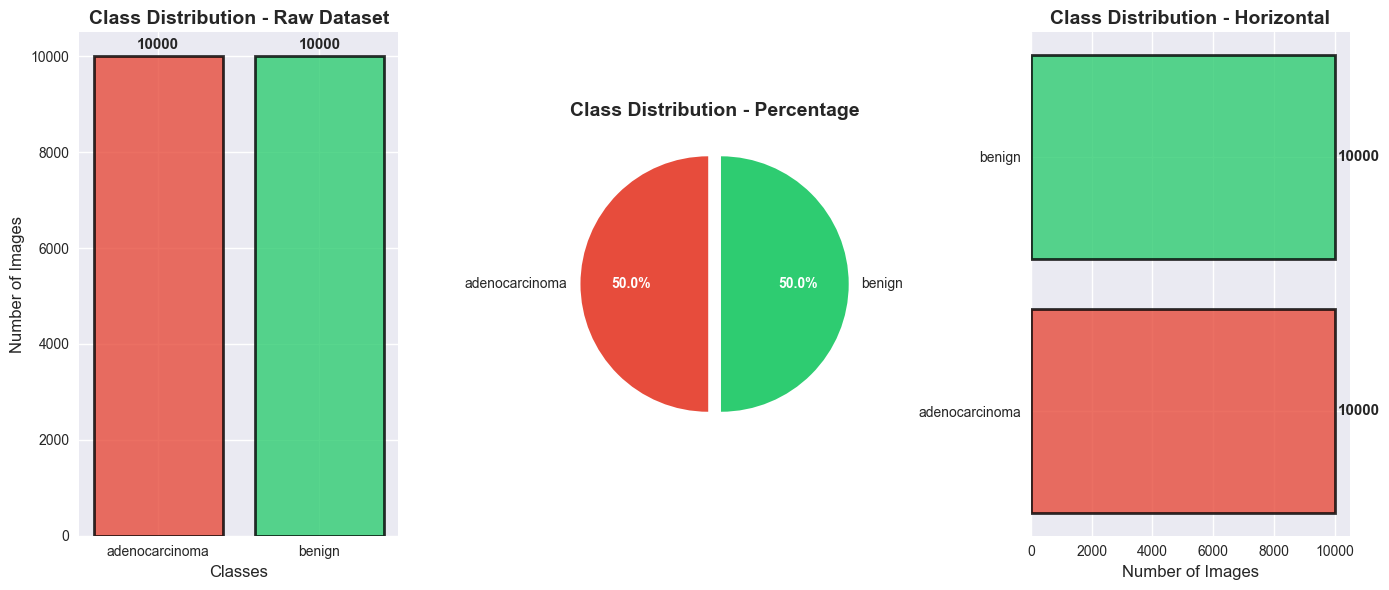

In [4]:
# %%
"""
# 📊 Dataset Setup and Analysis
Visual Intelligence Project - DeepLIFT Assignment
Phase 1: Data & CNN Foundation (Day 1)

**Objective**: Analyze raw lung cancer dataset, create train/test split, and prepare data pipeline
**Dataset**: Kaggle lung cancer histopathological images (adenocarcinoma vs benign)
**Target**: 80/20 train/test split with class analysis
"""

# %%
# =============================================================================
# 📦 IMPORTS AND SETUP
# =============================================================================

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import shutil
from pathlib import Path
from collections import Counter
import json

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🖥️  Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

# %%
# =============================================================================
# 🗂️ PATH CONFIGURATION
# =============================================================================

# Define paths robustly relative to the notebook location
NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent
RAW_DATA_PATH = PROJECT_ROOT / "data" / "raw"
PROCESSED_DATA_PATH = PROJECT_ROOT / "data" / "processed"
RESULTS_PATH = PROJECT_ROOT / "results"

# Create results directory if it doesn't exist
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

print("📁 Project Paths:")
print(f"Project Root: {PROJECT_ROOT}")
print(f"Raw Data: {RAW_DATA_PATH}")
print(f"Processed Data: {PROCESSED_DATA_PATH}")
print(f"Results: {RESULTS_PATH}")

# Verify raw data exists
if RAW_DATA_PATH.exists():
    print("✅ Raw data directory found!")
else:
    print("❌ Raw data directory not found!")
    print("Please ensure the dataset is downloaded to data/raw/")

# %%
# =============================================================================
# 🔍 DATASET ANALYSIS FUNCTIONS
# =============================================================================

def analyze_raw_dataset(data_path):
    """Analyze the raw dataset structure and class distribution"""
    
    data_path = Path(data_path)
    classes = ['adenocarcinoma', 'benign']
    
    print("📊 DATASET ANALYSIS")
    print("=" * 50)
    
    class_counts = {}
    total_images = 0
    image_extensions = {}
    
    for class_name in classes:
        class_path = data_path / class_name
        if class_path.exists():
            # Count images by extension
            extensions = ['.jpeg', '.jpg', '.png', '.bmp', '.tiff']
            class_images = []
            ext_count = {}
            
            for ext in extensions:
                files = list(class_path.glob(f'*{ext}')) + list(class_path.glob(f'*{ext.upper()}'))
                class_images.extend(files)
                if files:
                    ext_count[ext] = len(files)
            
            class_counts[class_name] = len(class_images)
            image_extensions[class_name] = ext_count
            total_images += len(class_images)
            
            print(f"{class_name.capitalize()}: {len(class_images)} images")
            if ext_count:
                print(f"  Extensions: {ext_count}")
        else:
            print(f"⚠️  Warning: {class_path} not found!")
            class_counts[class_name] = 0
            image_extensions[class_name] = {}
    
    print(f"\nTotal images: {total_images}")
    
    # Calculate class balance
    if total_images > 0:
        class_balance = {cls: (count/total_images)*100 for cls, count in class_counts.items()}
        print(f"Class balance: {class_balance}")
        
        # Check if dataset is balanced (within 10% difference)
        balance_diff = abs(class_balance['adenocarcinoma'] - class_balance['benign'])
        if balance_diff <= 10:
            print("✅ Dataset is reasonably balanced")
        else:
            print("⚠️  Dataset is imbalanced - consider class weighting")
    
    return class_counts, total_images, image_extensions

def visualize_class_distribution(class_counts):
    """Visualize class distribution with enhanced plots"""
    
    plt.figure(figsize=(14, 6))
    
    classes_names = list(class_counts.keys())
    counts = list(class_counts.values())
    colors = ['#E74C3C', '#2ECC71']  # Red for adenocarcinoma, Green for benign
    
    # Bar plot
    plt.subplot(1, 3, 1)
    bars = plt.bar(classes_names, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    plt.title('Class Distribution - Raw Dataset', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Images', fontsize=12)
    plt.xlabel('Classes', fontsize=12)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01, 
                str(count), ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Pie chart
    plt.subplot(1, 3, 2)
    wedges, texts, autotexts = plt.pie(counts, labels=classes_names, colors=colors, 
                                       autopct='%1.1f%%', startangle=90, explode=(0.05, 0.05))
    plt.title('Class Distribution - Percentage', fontsize=14, fontweight='bold')
    
    # Enhance pie chart text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    # Horizontal bar chart for better readability
    plt.subplot(1, 3, 3)
    bars_h = plt.barh(classes_names, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    plt.title('Class Distribution - Horizontal', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Images', fontsize=12)
    
    # Add value labels
    for bar, count in zip(bars_h, counts):
        plt.text(bar.get_width() + max(counts)*0.01, bar.get_y() + bar.get_height()/2, 
                str(count), ha='left', va='center', fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'class_distribution_raw.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return True

# %%
# =============================================================================
# 📊 STEP 1: ANALYZE RAW DATASET
# =============================================================================

print("🚀 STARTING DATASET ANALYSIS")
print("=" * 60)

# Analyze the raw dataset
class_counts, total_images, image_extensions = analyze_raw_dataset(RAW_DATA_PATH)

# Visualize class distribution
if total_images > 0:
    visualize_class_distribution(class_counts)
else:
    print("❌ No images found. Please check your data directory structure.")

# %%
# =============================================================================
# 🔄 TRAIN/TEST SPLIT FUNCTIONS  
# =============================================================================

def create_train_test_split(raw_data_path, processed_data_path, test_size=0.2, random_state=42):
    """
    Create train/test split (80/20) and organize files with better error handling
    """
    
    raw_path = Path(raw_data_path)
    processed_path = Path(processed_data_path)
    
    print("🔄 CREATING TRAIN/TEST SPLIT")
    print("=" * 50)
    
    classes = ['adenocarcinoma', 'benign']
    split_info = {}
    
    # Clear existing processed data
    if processed_path.exists():
        print("🧹 Cleaning existing processed data...")
        shutil.rmtree(processed_path)
    
    for class_name in classes:
        print(f"\nProcessing {class_name} class...")
        
        # Get all image files for this class
        class_path = raw_path / class_name
        if not class_path.exists():
            print(f"❌ Class directory {class_path} not found!")
            continue
            
        image_files = []
        extensions = ['*.jpeg', '*.jpg', '*.png', '*.bmp', '*.tiff', '*.JPEG', '*.JPG', '*.PNG']
        
        for ext in extensions:
            image_files.extend(list(class_path.glob(ext)))
        
        if len(image_files) == 0:
            print(f"❌ No images found in {class_path}")
            continue
            
        print(f"Found {len(image_files)} images")
        
        # Create train/test split
        if len(image_files) < 10:
            print(f"⚠️  Warning: Only {len(image_files)} images found. Consider getting more data.")
        
        train_files, test_files = train_test_split(
            image_files, 
            test_size=test_size, 
            random_state=random_state,
            shuffle=True
        )
        
        print(f"Train: {len(train_files)} images ({(1-test_size)*100:.0f}%)")
        print(f"Test: {len(test_files)} images ({test_size*100:.0f}%)")
        
        # Create directories
        train_dir = processed_path / 'train' / class_name
        test_dir = processed_path / 'test' / class_name
        train_dir.mkdir(parents=True, exist_ok=True)
        test_dir.mkdir(parents=True, exist_ok=True)
        
        # Copy files with progress tracking
        print("📁 Copying train files...")
        for i, file_path in enumerate(train_files):
            dest_path = train_dir / f"{class_name}_train_{i:04d}{file_path.suffix.lower()}"
            try:
                shutil.copy2(file_path, dest_path)
            except Exception as e:
                print(f"Error copying {file_path}: {e}")
        
        print("📁 Copying test files...")
        for i, file_path in enumerate(test_files):
            dest_path = test_dir / f"{class_name}_test_{i:04d}{file_path.suffix.lower()}"
            try:
                shutil.copy2(file_path, dest_path)
            except Exception as e:
                print(f"Error copying {file_path}: {e}")
        
        split_info[class_name] = {
            'total': len(image_files),
            'train': len(train_files),
            'test': len(test_files),
            'train_percentage': (len(train_files) / len(image_files)) * 100,
            'test_percentage': (len(test_files) / len(image_files)) * 100
        }
    
    # Save split information
    split_info_path = RESULTS_PATH / 'dataset_split_info.json'
    with open(split_info_path, 'w') as f:
        json.dump(split_info, f, indent=2)
    
    print(f"\n✅ Train/Test split completed!")
    print(f"📁 Processed data saved to: {processed_path}")
    print(f"📊 Split info saved to: {split_info_path}")
    
    return split_info

def visualize_split_info(split_info):
    """Visualize the train/test split information with enhanced plots"""
    
    classes = list(split_info.keys())
    train_counts = [split_info[cls]['train'] for cls in classes]
    test_counts = [split_info[cls]['test'] for cls in classes]
    total_counts = [split_info[cls]['total'] for cls in classes]
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Train/Test Split Analysis', fontsize=16, fontweight='bold')
    
    # 1. Grouped bar chart
    x = np.arange(len(classes))
    width = 0.35
    
    ax1 = axes[0, 0]
    bars1 = ax1.bar(x - width/2, train_counts, width, label='Train (80%)', 
                   color='#3498DB', alpha=0.8, edgecolor='black')
    bars2 = ax1.bar(x + width/2, test_counts, width, label='Test (20%)', 
                   color='#E67E22', alpha=0.8, edgecolor='black')
    
    ax1.set_xlabel('Classes', fontsize=12)
    ax1.set_ylabel('Number of Images', fontsize=12)
    ax1.set_title('Train/Test Split by Class', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([cls.capitalize() for cls in classes])
    ax1.legend()
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + max(train_counts + test_counts)*0.01,
                   f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Stacked bar chart
    ax2 = axes[0, 1]
    ax2.bar(classes, train_counts, label='Train', color='#3498DB', alpha=0.8)
    ax2.bar(classes, test_counts, bottom=train_counts, label='Test', color='#E67E22', alpha=0.8)
    ax2.set_title('Total Distribution (Stacked)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Images', fontsize=12)
    ax2.legend()
    
    # Add total labels
    for i, (cls, total) in enumerate(zip(classes, total_counts)):
        ax2.text(i, total + max(total_counts)*0.01, f'{total}', 
                ha='center', va='bottom', fontweight='bold')
    
    # 3. Pie chart for total distribution
    ax3 = axes[1, 0]
    colors_pie = ['#E74C3C', '#2ECC71']
    wedges, texts, autotexts = ax3.pie(total_counts, labels=[cls.capitalize() for cls in classes], 
                                       colors=colors_pie, autopct='%1.1f%%', startangle=90)
    ax3.set_title('Total Class Distribution', fontsize=14, fontweight='bold')
    
    # 4. Train/Test ratio visualization
    ax4 = axes[1, 1]
    train_ratios = [split_info[cls]['train_percentage'] for cls in classes]
    test_ratios = [split_info[cls]['test_percentage'] for cls in classes]
    
    x_pos = np.arange(len(classes))
    ax4.barh(x_pos - 0.2, train_ratios, 0.4, label='Train %', color='#3498DB', alpha=0.8)
    ax4.barh(x_pos + 0.2, test_ratios, 0.4, label='Test %', color='#E67E22', alpha=0.8)
    ax4.set_yticks(x_pos)
    ax4.set_yticklabels([cls.capitalize() for cls in classes])
    ax4.set_xlabel('Percentage', fontsize=12)
    ax4.set_title('Train/Test Percentage by Class', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.set_xlim(0, 100)
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'train_test_split_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return True


🔄 CREATING TRAIN/TEST SPLIT
🧹 Cleaning existing processed data...

Processing adenocarcinoma class...
Found 10000 images
Train: 8000 images (80%)
Test: 2000 images (20%)
📁 Copying train files...
📁 Copying test files...

Processing benign class...
Found 10000 images
Train: 8000 images (80%)
Test: 2000 images (20%)
📁 Copying train files...
📁 Copying test files...

✅ Train/Test split completed!
📁 Processed data saved to: D:\University\4th Semester\4. Visual Intelligence\Project\data\processed
📊 Split info saved to: D:\University\4th Semester\4. Visual Intelligence\Project\results\dataset_split_info.json



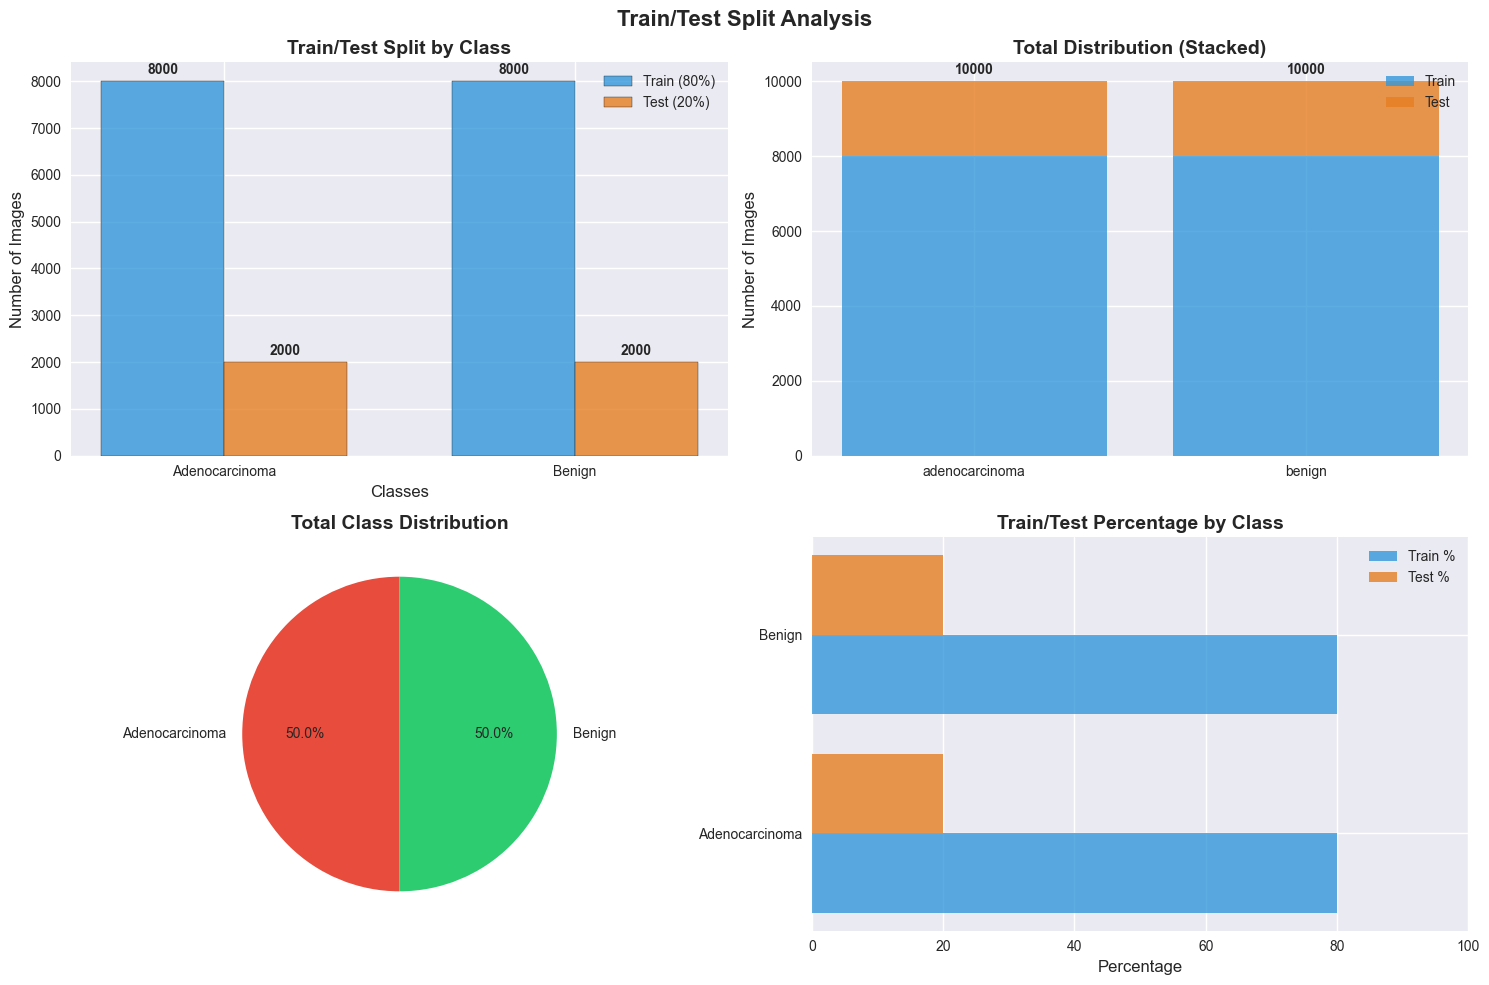


📊 DETAILED TRAIN/TEST SPLIT SUMMARY
Class           Total    Train    Test     Train %    Test %    
--------------------------------------------------------------------------------
Adenocarcinoma  10000    8000     2000     80.0       20.0      
Benign          10000    8000     2000     80.0       20.0      
--------------------------------------------------------------------------------
TOTAL           20000    16000    4000     80.0       20.0      


In [5]:
# %%
# =============================================================================
# 🔄 STEP 2: CREATE TRAIN/TEST SPLIT
# =============================================================================

if total_images > 0:
    print("\n" + "="*60)
    split_info = create_train_test_split(RAW_DATA_PATH, PROCESSED_DATA_PATH, test_size=0.2, random_state=42)
    
    # Visualize split information
    if split_info:
        print("\n" + "="*60)
        visualize_split_info(split_info)
        
        # Print detailed summary table
        print("\n📊 DETAILED TRAIN/TEST SPLIT SUMMARY")
        print("=" * 80)
        print(f"{'Class':<15} {'Total':<8} {'Train':<8} {'Test':<8} {'Train %':<10} {'Test %':<10}")
        print("-" * 80)
        
        total_all = sum(split_info[cls]['total'] for cls in split_info.keys())
        train_all = sum(split_info[cls]['train'] for cls in split_info.keys())
        test_all = sum(split_info[cls]['test'] for cls in split_info.keys())
        
        for class_name in split_info.keys():
            info = split_info[class_name]
            print(f"{class_name.capitalize():<15} {info['total']:<8} {info['train']:<8} {info['test']:<8} "
                  f"{info['train_percentage']:<10.1f} {info['test_percentage']:<10.1f}")
        
        print("-" * 80)
        print(f"{'TOTAL':<15} {total_all:<8} {train_all:<8} {test_all:<8} "
              f"{(train_all/total_all)*100:<10.1f} {(test_all/total_all)*100:<10.1f}")
    else:
        print("❌ Failed to create train/test split")
else:
    print("❌ Skipping train/test split due to no images found")

# %%
# =============================================================================
# 🖼️ SAMPLE VISUALIZATION FUNCTIONS
# =============================================================================

def analyze_image_properties(processed_data_path, sample_size=50):
    """Analyze image properties like dimensions, file sizes, etc."""
    
    processed_path = Path(processed_data_path)
    classes = ['adenocarcinoma', 'benign']
    
    print("🔍 ANALYZING IMAGE PROPERTIES")
    print("=" * 50)
    
    all_properties = {cls: {'widths': [], 'heights': [], 'sizes': [], 'aspects': []} for cls in classes}
    
    for class_name in classes:
        train_dir = processed_path / 'train' / class_name
        if train_dir.exists():
            image_files = list(train_dir.glob('*'))[:sample_size]
            
            print(f"\nAnalyzing {len(image_files)} {class_name} images...")
            
            for img_path in image_files:
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        aspect_ratio = width / height
                        file_size = img_path.stat().st_size / (1024 * 1024)  # MB
                        
                        all_properties[class_name]['widths'].append(width)
                        all_properties[class_name]['heights'].append(height)
                        all_properties[class_name]['sizes'].append(file_size)
                        all_properties[class_name]['aspects'].append(aspect_ratio)
                        
                except Exception as e:
                    print(f"Error analyzing {img_path}: {e}")
    
    # Visualize properties
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Image Properties Analysis', fontsize=16, fontweight='bold')
    
    colors = ['#E74C3C', '#2ECC71']
    
    # Width distribution
    axes[0, 0].hist([all_properties[cls]['widths'] for cls in classes], 
                    bins=20, alpha=0.7, label=classes, color=colors)
    axes[0, 0].set_title('Width Distribution')
    axes[0, 0].set_xlabel('Width (pixels)')
    axes[0, 0].legend()
    
    # Height distribution  
    axes[0, 1].hist([all_properties[cls]['heights'] for cls in classes],
                    bins=20, alpha=0.7, label=classes, color=colors)
    axes[0, 1].set_title('Height Distribution')
    axes[0, 1].set_xlabel('Height (pixels)')
    axes[0, 1].legend()
    
    # Aspect ratio distribution
    axes[0, 2].hist([all_properties[cls]['aspects'] for cls in classes],
                    bins=20, alpha=0.7, label=classes, color=colors)
    axes[0, 2].set_title('Aspect Ratio Distribution')
    axes[0, 2].set_xlabel('Width/Height Ratio')
    axes[0, 2].legend()
    
    # File size distribution
    axes[1, 0].hist([all_properties[cls]['sizes'] for cls in classes],
                    bins=20, alpha=0.7, label=classes, color=colors)
    axes[1, 0].set_title('File Size Distribution')
    axes[1, 0].set_xlabel('Size (MB)')
    axes[1, 0].legend()
    
    # Scatter: Width vs Height
    for i, cls in enumerate(classes):
        axes[1, 1].scatter(all_properties[cls]['widths'], all_properties[cls]['heights'],
                          alpha=0.6, label=cls.capitalize(), color=colors[i])
    axes[1, 1].set_title('Width vs Height')
    axes[1, 1].set_xlabel('Width (pixels)')
    axes[1, 1].set_ylabel('Height (pixels)')
    axes[1, 1].legend()
    
    # Box plot for aspect ratios
    data_for_box = [all_properties[cls]['aspects'] for cls in classes]
    box_plot = axes[1, 2].boxplot(data_for_box, labels=[cls.capitalize() for cls in classes],
                                  patch_artist=True)
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    axes[1, 2].set_title('Aspect Ratio Box Plot')
    axes[1, 2].set_ylabel('Aspect Ratio')
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'image_properties_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\n📊 IMAGE STATISTICS SUMMARY")
    print("=" * 80)
    for class_name in classes:
        props = all_properties[class_name]
        if props['widths']:
            print(f"\n{class_name.upper()} CLASS:")
            print(f"  Width:  {np.mean(props['widths']):.0f} ± {np.std(props['widths']):.0f} pixels")
            print(f"  Height: {np.mean(props['heights']):.0f} ± {np.std(props['heights']):.0f} pixels") 
            print(f"  Size:   {np.mean(props['sizes']):.2f} ± {np.std(props['sizes']):.2f} MB")
            print(f"  Aspect: {np.mean(props['aspects']):.2f} ± {np.std(props['aspects']):.2f}")
    
    return all_properties

def visualize_sample_images(processed_data_path, samples_per_class=4):
    """Visualize sample images from each class with enhanced display"""
    
    processed_path = Path(processed_data_path)
    classes = ['adenocarcinoma', 'benign']
    
    fig, axes = plt.subplots(2, samples_per_class, figsize=(16, 8))
    fig.suptitle('Sample Images from Processed Dataset', fontsize=16, fontweight='bold')
    
    class_colors = ['#E74C3C', '#2ECC71']
    
    for class_idx, class_name in enumerate(classes):
        train_dir = processed_path / 'train' / class_name
        
        if not train_dir.exists():
            for img_idx in range(samples_per_class):
                axes[class_idx, img_idx].text(0.5, 0.5, f'No data found\nfor {class_name}', 
                                            ha='center', va='center', fontsize=10)
                axes[class_idx, img_idx].axis('off')
            continue
            
        image_files = list(train_dir.glob('*'))
        
        if len(image_files) < samples_per_class:
            print(f"⚠️  Only {len(image_files)} images available for {class_name}, showing all")
            
        selected_files = image_files[:samples_per_class]
        
        for img_idx in range(samples_per_class):
            if img_idx < len(selected_files):
                img_path = selected_files[img_idx]
                try:
                    # Load and display image
                    img = Image.open(img_path).convert('RGB')
                    axes[class_idx, img_idx].imshow(img)
                    
                    # Enhanced title with more info
                    file_size = img_path.stat().st_size / 1024  # KB
                    title = f'{class_name.capitalize()}\n{img.size[0]}×{img.size[1]} | {file_size:.0f}KB'
                    axes[class_idx, img_idx].set_title(title, fontsize=10, color=class_colors[class_idx], fontweight='bold')
                    axes[class_idx, img_idx].axis('off')
                    
                    # Add border with class color
                    for spine in axes[class_idx, img_idx].spines.values():
                        spine.set_edgecolor(class_colors[class_idx])
                        spine.set_linewidth(3)
                        spine.set_visible(True)
                    
                except Exception as e:
                    axes[class_idx, img_idx].text(0.5, 0.5, f'Error loading\n{img_path.name}\n{str(e)[:30]}...', 
                                                ha='center', va='center', fontsize=8)
                    axes[class_idx, img_idx].axis('off')
            else:
                axes[class_idx, img_idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()




🔍 ANALYZING IMAGE PROPERTIES

Analyzing 100 adenocarcinoma images...

Analyzing 100 benign images...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_9432\1027407389.py:121: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1, 2].boxplot(data_for_box, labels=[cls.capitalize() for cls in classes],


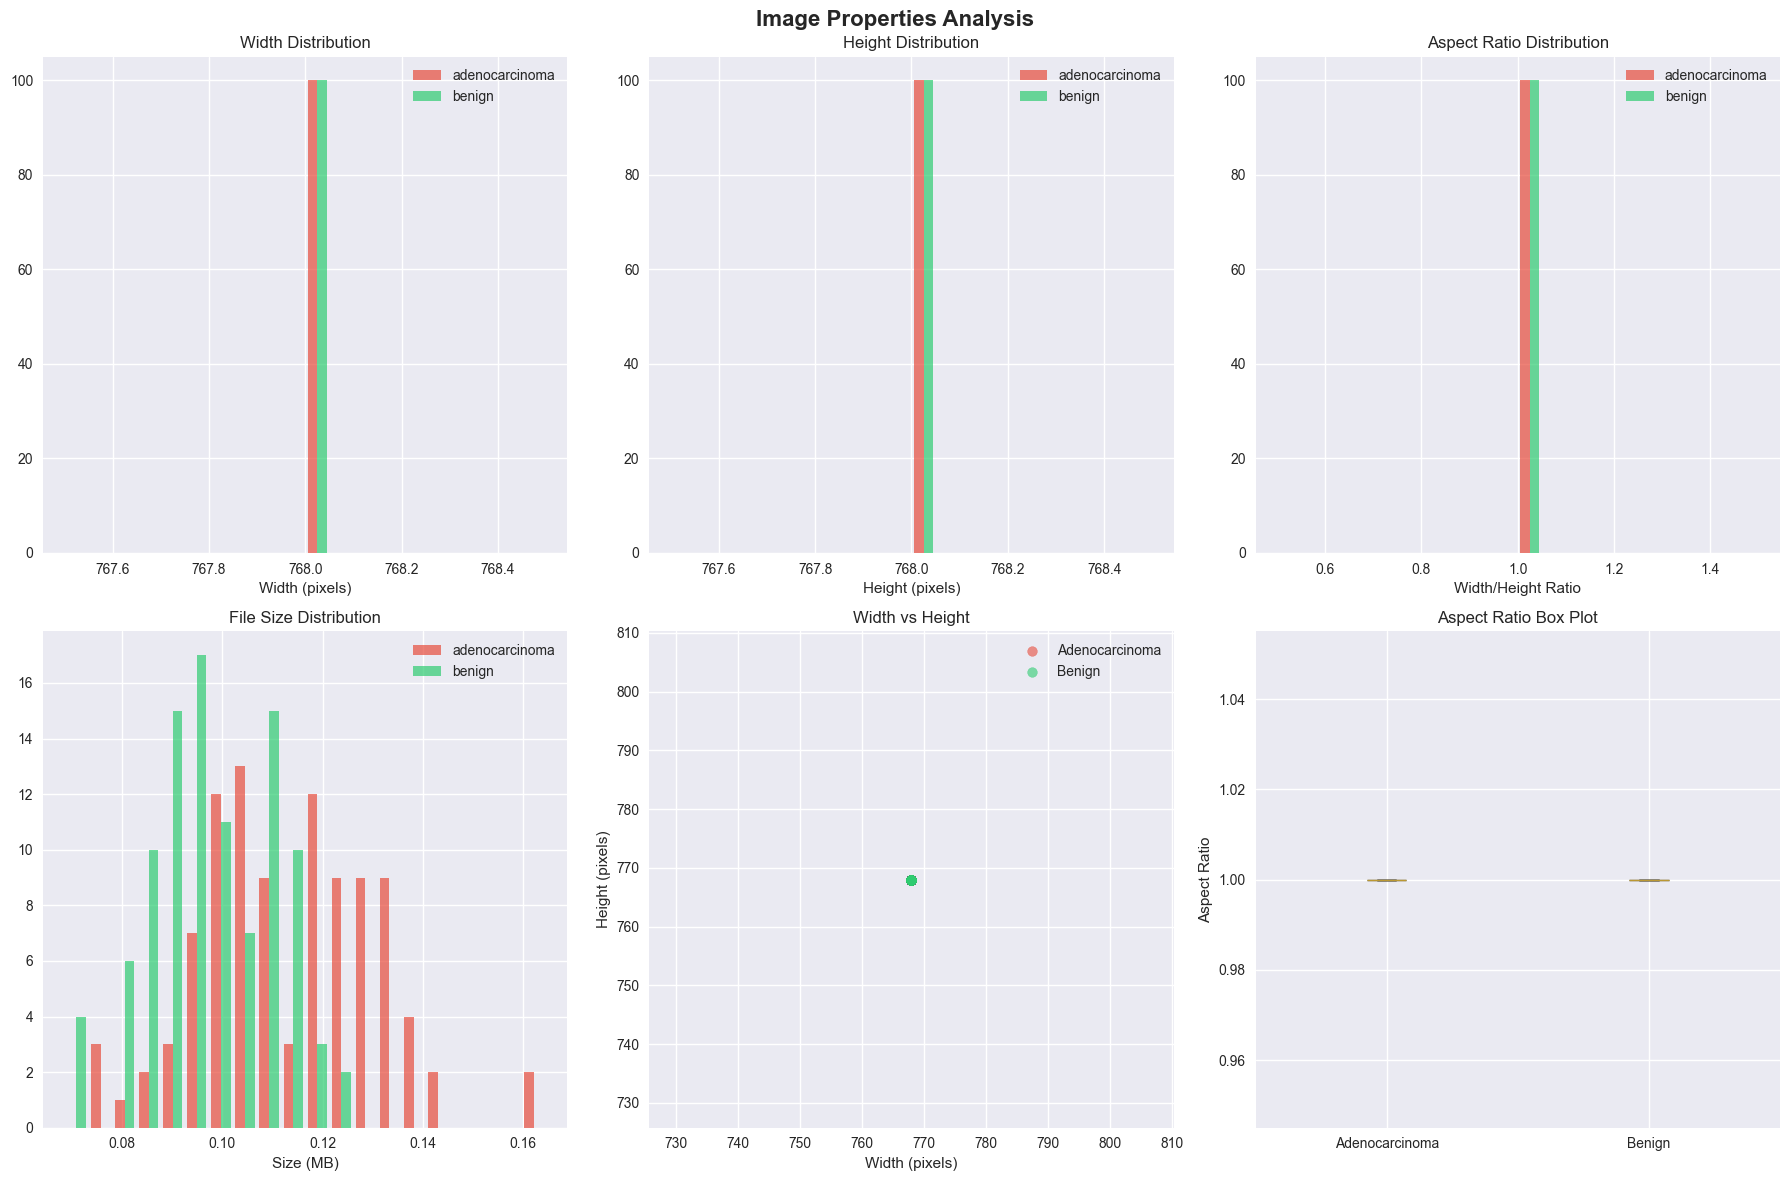


📊 IMAGE STATISTICS SUMMARY

ADENOCARCINOMA CLASS:
  Width:  768 ± 0 pixels
  Height: 768 ± 0 pixels
  Size:   0.11 ± 0.02 MB
  Aspect: 1.00 ± 0.00

BENIGN CLASS:
  Width:  768 ± 0 pixels
  Height: 768 ± 0 pixels
  Size:   0.10 ± 0.01 MB
  Aspect: 1.00 ± 0.00

🖼️  VISUALIZING SAMPLE IMAGES


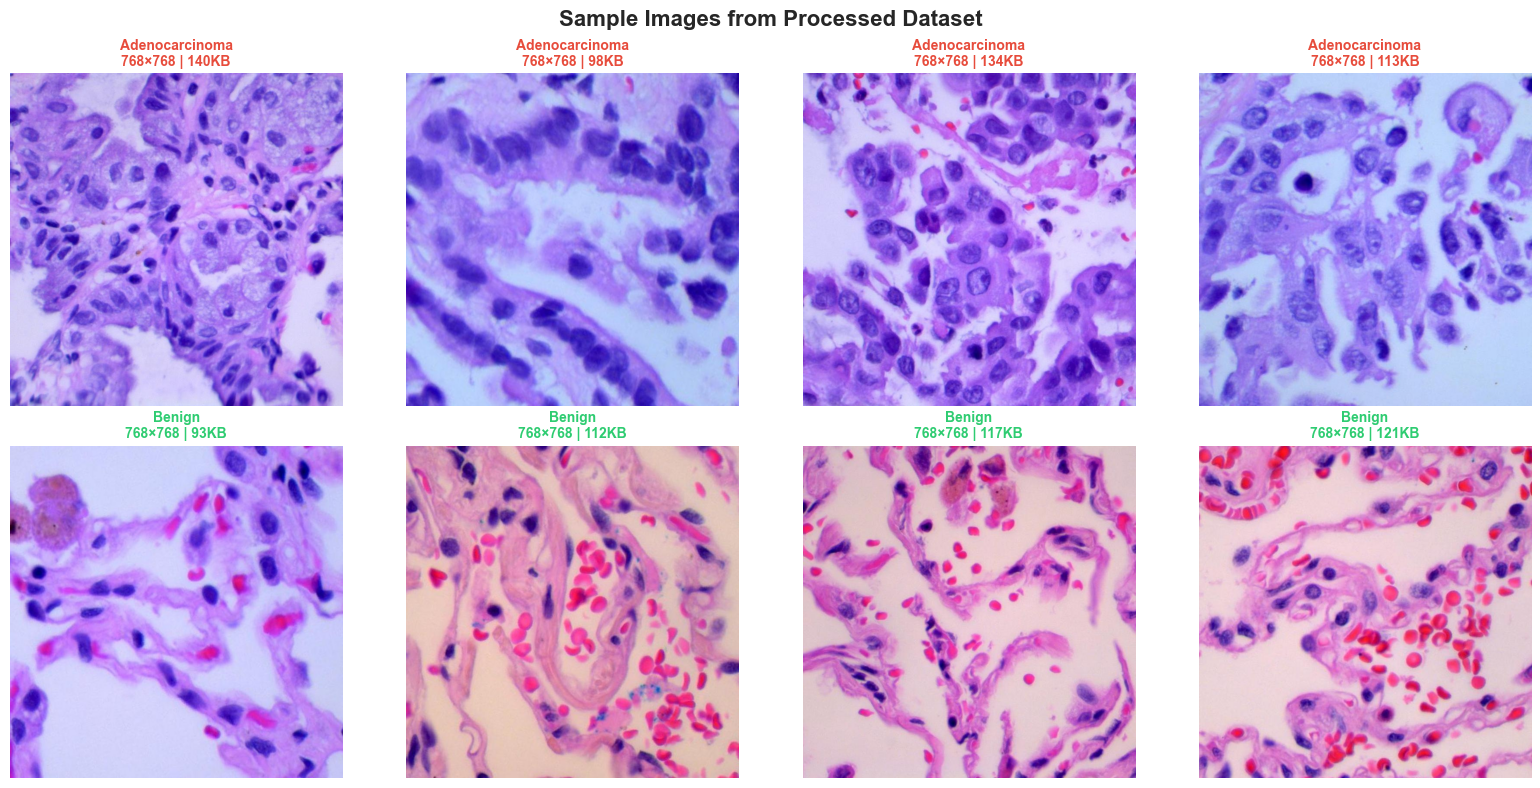


🎯 DATASET SETUP SUMMARY
✅ Dataset successfully processed!
📊 Total images: 20000
🚂 Training images: 16000 (80.0%)
🧪 Testing images: 4000 (20.0%)
📁 Processed data location: D:\University\4th Semester\4. Visual Intelligence\Project\data\processed
📊 Results saved to: D:\University\4th Semester\4. Visual Intelligence\Project\results

🎯 PROJECT REQUIREMENTS CHECK:
✅ Binary classification: adenocarcinoma vs benign
✅ 80/20 train/test split completed
✅ Sufficient data: 10000 images per class (min: 100)

🚀 NEXT STEPS:
1. 📝 Proceed to: 02_cnn_implementation/01_cnn_architecture.ipynb
2. 🎯 Target: >70% accuracy for both CNN and ScatNet
3. 🔧 Implement data augmentation pipeline
4. 🏗️ Design CNN architecture
5. ⚡ Setup training pipeline with validation

📚 DELIVERABLES COMPLETED:
✅ Dataset ready + analysis plots
✅ Train/test split (80/20)
✅ Class distribution analysis
✅ Image properties analysis
✅ Sample visualization
💾 Configuration saved to: D:\University\4th Semester\4. Visual Intelligence\Project

In [ ]:
# %%
# =============================================================================
# 🖼️ STEP 3: ANALYZE IMAGE PROPERTIES
# =============================================================================

if PROCESSED_DATA_PATH.exists():
    print("\n" + "="*60)
    image_properties = analyze_image_properties(PROCESSED_DATA_PATH, sample_size=100)
else:
    print("❌ Processed data not found. Please run the train/test split first.")

# %%
# =============================================================================
# 🖼️ STEP 4: VISUALIZE SAMPLE IMAGES  
# =============================================================================

if PROCESSED_DATA_PATH.exists():
    print("\n" + "="*60)
    print("🖼️  VISUALIZING SAMPLE IMAGES")
    print("=" * 50)
    visualize_sample_images(PROCESSED_DATA_PATH, samples_per_class=4)
else:
    print("❌ Processed data not found. Please run the train/test split first.")

# %%
# =============================================================================
# 📋 FINAL SUMMARY & NEXT STEPS
# =============================================================================

print("\n" + "🎯 DATASET SETUP SUMMARY")
print("=" * 60)

if total_images > 0 and split_info:
    total_train = sum(split_info[cls]['train'] for cls in split_info.keys())
    total_test = sum(split_info[cls]['test'] for cls in split_info.keys())
    
    print(f"✅ Dataset successfully processed!")
    print(f"📊 Total images: {total_images}")
    print(f"🚂 Training images: {total_train} ({(total_train/total_images)*100:.1f}%)")
    print(f"🧪 Testing images: {total_test} ({(total_test/total_images)*100:.1f}%)")
    print(f"📁 Processed data location: {PROCESSED_DATA_PATH}")
    print(f"📊 Results saved to: {RESULTS_PATH}")
    
    # Check minimum requirements
    min_accuracy_target = 0.70
    min_images_per_class = 100
    
    print(f"\n🎯 PROJECT REQUIREMENTS CHECK:")
    print(f"✅ Binary classification: adenocarcinoma vs benign")
    print(f"✅ 80/20 train/test split completed")
    
    min_class_size = min(split_info[cls]['total'] for cls in split_info.keys())
    if min_class_size >= min_images_per_class:
        print(f"✅ Sufficient data: {min_class_size} images per class (min: {min_images_per_class})")
    else:
        print(f"⚠️  Limited data: {min_class_size} images per class (recommended: {min_images_per_class}+)")
    
    print(f"\n🚀 NEXT STEPS:")
    print(f"1. 📝 Proceed to: 02_cnn_implementation/01_cnn_architecture.ipynb")
    print(f"2. 🎯 Target: >70% accuracy for both CNN and ScatNet")
    print(f"3. 🔧 Implement data augmentation pipeline")
    print(f"4. 🏗️ Design CNN architecture")
    print(f"5. ⚡ Setup training pipeline with validation")
    
else:
    print("❌ Dataset setup incomplete. Please check the following:")
    print("   • Raw data directory exists and contains adenocarcinoma/benign folders")
    print("   • Image files are in supported formats (.jpg, .jpeg, .png)")
    print("   • Sufficient permissions to create processed data directories")

print(f"\n📚 DELIVERABLES COMPLETED:")
print(f"✅ Dataset ready + analysis plots")
print(f"✅ Train/test split (80/20)")
print(f"✅ Class distribution analysis")
print(f"✅ Image properties analysis")
print(f"✅ Sample visualization")

# %%
# =============================================================================
# 💾 SAVE CONFIGURATION FOR NEXT NOTEBOOKS
# =============================================================================

# Save configuration that will be used in subsequent notebooks
config = {
    "dataset": {
        "raw_path": str(RAW_DATA_PATH),
        "processed_path": str(PROCESSED_DATA_PATH),
        "classes": ["adenocarcinoma", "benign"],
        "class_to_idx": {"adenocarcinoma": 0, "benign": 1},
        "total_images": total_images if 'total_images' in locals() else 0,
        "split_ratio": {"train": 0.8, "test": 0.2}
    },
    "requirements": {
        "minimum_accuracy": 0.70,
        "assigned_method": "DeepLIFT",
        "deliverables": {
            "report_pages": "6-8",
            "presentation_minutes": 18,
            "exam_date": "June 27, 2025"
        }
    },
    "paths": {
        "project_root": str(PROJECT_ROOT),
        "results": str(RESULTS_PATH),
        "models": str(PROJECT_ROOT / "models"),
        "notebooks": str(PROJECT_ROOT / "notebooks")
    }
}

# Add split information if available
if 'split_info' in locals() and split_info:
    config["dataset"]["split_info"] = split_info

# Add image properties if available  
if 'image_properties' in locals() and image_properties:
    # Convert numpy arrays to lists for JSON serialization
    image_stats = {}
    for class_name in image_properties:
        if image_properties[class_name]['widths']:
            image_stats[class_name] = {
                "avg_width": float(np.mean(image_properties[class_name]['widths'])),
                "avg_height": float(np.mean(image_properties[class_name]['heights'])),
                "avg_aspect_ratio": float(np.mean(image_properties[class_name]['aspects'])),
                "avg_file_size_mb": float(np.mean(image_properties[class_name]['sizes']))
            }
    config["dataset"]["image_stats"] = image_stats

# Save configuration
config_path = PROJECT_ROOT / "config.json"
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print(f"💾 Configuration saved to: {config_path}")
print(f"   This will be used by subsequent notebooks for consistent paths and settings")

# %%
# =============================================================================
# 🔧 DATA LOADING PIPELINE PREVIEW
# =============================================================================

class LungCancerDataset(Dataset):
    """Custom dataset class for lung cancer images - Preview for next notebooks"""
    
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = Path(data_dir) / split
        self.transform = transform
        self.classes = ['adenocarcinoma', 'benign']
        self.class_to_idx = {'adenocarcinoma': 0, 'benign': 1}
        self.samples = []
        
        self._load_samples()
    
    def _load_samples(self):
        """Load all image paths with labels"""
        for class_name in self.classes:
            class_dir = self.data_dir / class_name
            if class_dir.exists():
                for img_path in class_dir.glob('*'):
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        self.samples.append((str(img_path), self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a dummy tensor and label
            return torch.zeros(3, 224, 224), label

# Define basic transforms that will be expanded in CNN notebook
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Test the dataset loading
if PROCESSED_DATA_PATH.exists():
    print("🔧 TESTING DATA LOADING PIPELINE")
    print("=" * 50)
    
    try:
        # Test train dataset
        train_dataset = LungCancerDataset(PROCESSED_DATA_PATH, split='train', transform=basic_transform)
        test_dataset = LungCancerDataset(PROCESSED_DATA_PATH, split='test', transform=basic_transform)
        
        print(f"✅ Train dataset: {len(train_dataset)} samples")
        print(f"✅ Test dataset: {len(test_dataset)} samples")
        
        # Test data loader
        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
        
        # Load one batch to verify everything works
        sample_batch = next(iter(train_loader))
        images, labels = sample_batch
        
        print(f"✅ Sample batch shape: {images.shape}")
        print(f"✅ Sample labels: {labels}")
        print(f"✅ Data pipeline working correctly!")
        
        # Show class distribution in datasets
        train_labels = [sample[1] for sample in train_dataset.samples]
        test_labels = [sample[1] for sample in test_dataset.samples]
        
        train_class_dist = Counter(train_labels)
        test_class_dist = Counter(test_labels)
        
        print(f"\n📊 Dataset Class Distribution:")
        print(f"Train - Adenocarcinoma: {train_class_dist[0]}, Benign: {train_class_dist[1]}")
        print(f"Test  - Adenocarcinoma: {test_class_dist[0]}, Benign: {test_class_dist[1]}")
        
    except Exception as e:
        print(f"❌ Error testing data pipeline: {e}")
        print("This will need to be fixed before proceeding to CNN implementation")

print(f"\n🎉 DATASET SETUP COMPLETE!")

    